In [332]:
# To generate predictions, set real_testing to True and ensure Test_Set_EEG.csv
# is in the working directory. rf_results.csv, svm_results.csv, and xgb_results.csv
# will be generated. Choose xgb_results.csv for judging.

import pandas as pd

df = pd.read_csv('Train_and_Validate_EEG.csv')
test_df = pd.read_csv('Test_Set_EEG.csv')

real_testing = False

In [333]:
# Remove unnecessary columns

df = df.iloc[:, :123]
test_df = test_df.iloc[:, :120]

df.drop(columns=['specific.disorder', 'ID', 'eeg.date'], inplace=True)
test_df_ids = test_df[['ID']]
test_df.drop(columns=['eeg.date', 'ID'], inplace=True)
test_df = test_df.dropna()

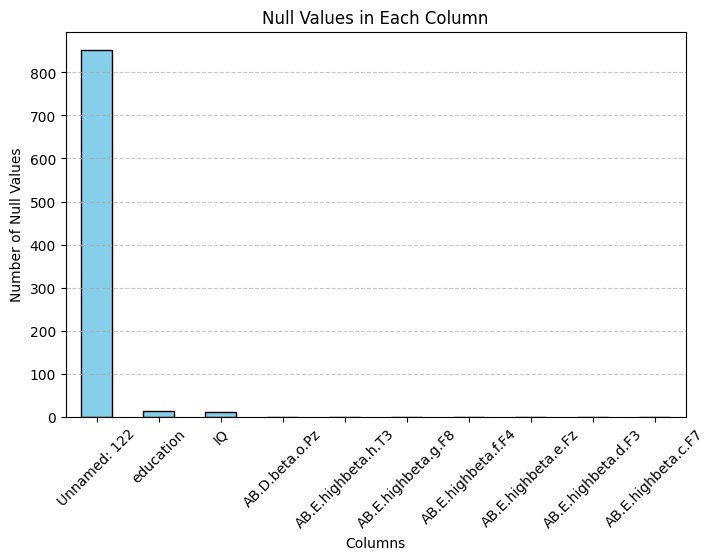

In [334]:
# Plot null values before removal

import numpy as np
import matplotlib.pyplot as plt

null_counts = df.isnull().sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))

null_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.title('Null Values in Each Column')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

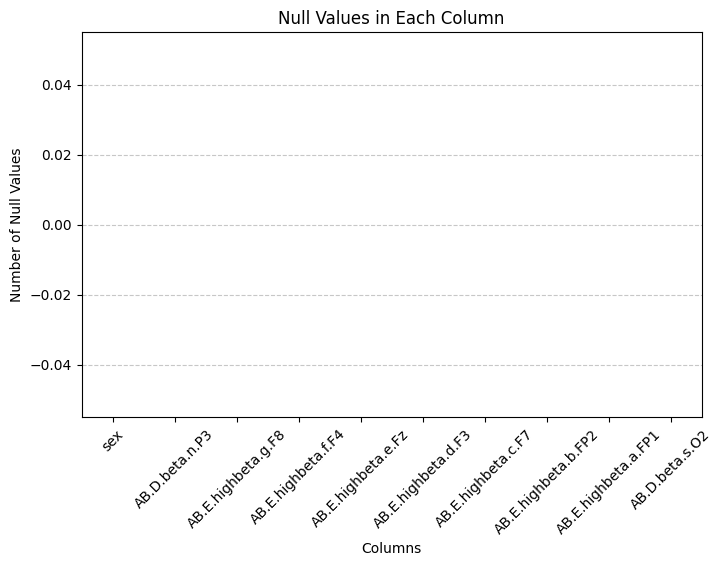

In [335]:
df_dropped = df.drop(columns=['Unnamed: 122']).dropna()

null_counts = df_dropped.isnull().sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
null_counts.plot(kind='bar')

plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.title('Null Values in Each Column')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

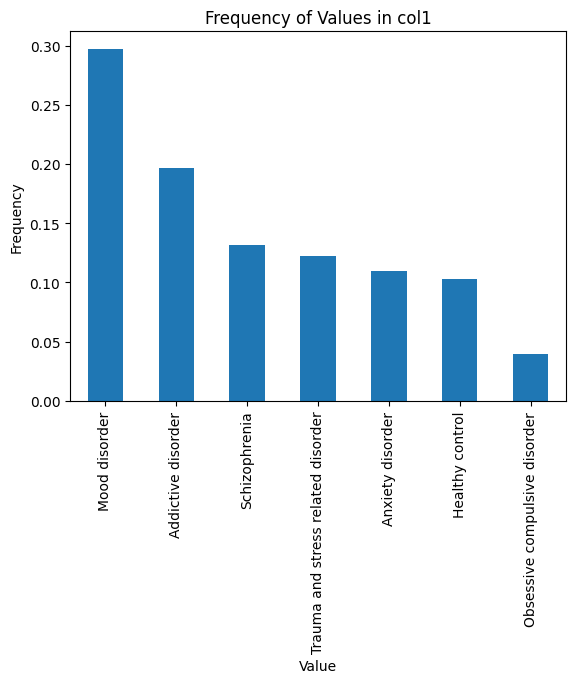

In [336]:
value_counts = df_dropped['main.disorder'].value_counts() / len(df_dropped)

value_counts.plot(kind='bar')
plt.title('Frequency of Values in col1')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [337]:
# Calculate correlation matrix, drop columns with > .95 correlation,
# demonstrable improvement in model performance.

df_numbers = df_dropped.select_dtypes(include=[np.number])
corr_matrix = df_numbers.corr().abs()
upper_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] > 0.95)]

print(to_drop)

df_deduplicate = df_dropped.drop(to_drop, axis=1)
test_df.drop(to_drop, axis=1, inplace=True)

print(len(to_drop))

['AB.B.theta.b.FP2', 'AB.B.theta.e.Fz', 'AB.B.theta.f.F4', 'AB.B.theta.k.C4', 'AB.C.alpha.b.FP2', 'AB.C.alpha.c.F7', 'AB.C.alpha.d.F3', 'AB.C.alpha.e.Fz', 'AB.C.alpha.f.F4', 'AB.C.alpha.g.F8', 'AB.C.alpha.i.C3', 'AB.C.alpha.j.Cz', 'AB.C.alpha.k.C4', 'AB.C.alpha.p.P4', 'AB.D.beta.b.FP2', 'AB.D.beta.e.Fz', 'AB.D.beta.f.F4', 'AB.E.highbeta.f.F4', 'AB.E.highbeta.p.P4', 'AB.F.gamma.f.F4', 'AB.F.gamma.o.Pz', 'AB.F.gamma.p.P4', 'AB.F.gamma.r.O1', 'AB.F.gamma.s.O2']
24


In [338]:
# An attempt at feature engineering, was not successful

"""
waves = ['alpha', 'beta', 'theta', 'delta']

for wave in waves:
  df_deduplicate[wave] = df_deduplicate[[x for x in df_deduplicate.columns if wave in x]].apply(sum, axis=1)
  test_df[wave] = test_df[[x for x in test_df.columns if wave in x]].apply(sum, axis=1)

df_deduplicate.to_csv('/content/pen.csv')


electrodes = list(set([x.split('.')[-1] for x in df_deduplicate.columns if x.startswith('AB')]))

for wave in electrodes:
  df_deduplicate[wave] = df_deduplicate[[x for x in df_deduplicate.columns if x.endswith(wave)]].apply(sum, axis=1)

df_deduplicate.to_csv('/content/pen.csv')
"""


"\nwaves = ['alpha', 'beta', 'theta', 'delta']\n\nfor wave in waves:\n  df_deduplicate[wave] = df_deduplicate[[x for x in df_deduplicate.columns if wave in x]].apply(sum, axis=1)\n  test_df[wave] = test_df[[x for x in test_df.columns if wave in x]].apply(sum, axis=1)\n\ndf_deduplicate.to_csv('/content/pen.csv')\n\n\nelectrodes = list(set([x.split('.')[-1] for x in df_deduplicate.columns if x.startswith('AB')]))\n\nfor wave in electrodes:\n  df_deduplicate[wave] = df_deduplicate[[x for x in df_deduplicate.columns if x.endswith(wave)]].apply(sum, axis=1)\n\ndf_deduplicate.to_csv('/content/pen.csv')\n"

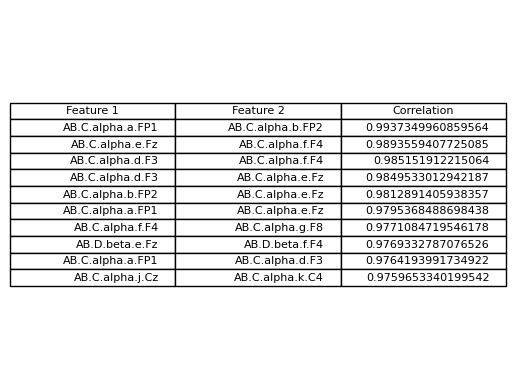

In [339]:
corr_unstacked = upper_matrix.stack().reset_index()
corr_unstacked.columns = ['Feature 1', 'Feature 2', 'Correlation']
corr_unstacked = corr_unstacked.sort_values(by='Correlation', ascending=False)
corr_unstacked_filtered = corr_unstacked[corr_unstacked['Correlation'] != 0]
corr_table = corr_unstacked_filtered.head(10)

fig, ax = plt.subplots()
ax.axis('off')
table = ax.table(cellText=corr_table.values, colLabels=corr_table.columns, loc='center')
plt.show()

In [340]:
from sklearn.preprocessing import LabelEncoder

df_deduplicate['sex'] = LabelEncoder().fit_transform(df_deduplicate['sex'])

test_df['sex'] = LabelEncoder().fit_transform(test_df['sex'])

In [341]:
from sklearn.model_selection import train_test_split

def generate_train_test(X, y, test_size=0.2, random_state=10):
  if real_testing:
    return X, test_df, y, y * 0
  return train_test_split(X, y, test_size=test_size)

Accuracy: 0.25301204819277107

Classification Report:
                                    precision    recall  f1-score   support

                Addictive disorder       0.38      0.41      0.39        29
                  Anxiety disorder       0.20      0.16      0.18        19
                   Healthy control       0.24      0.35      0.29        17
                     Mood disorder       0.38      0.13      0.19        47
     Obsessive compulsive disorder       0.00      0.00      0.00         6
                     Schizophrenia       0.20      0.35      0.25        23
Trauma and stress related disorder       0.26      0.28      0.27        25

                          accuracy                           0.25       166
                         macro avg       0.24      0.24      0.22       166
                      weighted avg       0.29      0.25      0.25       166



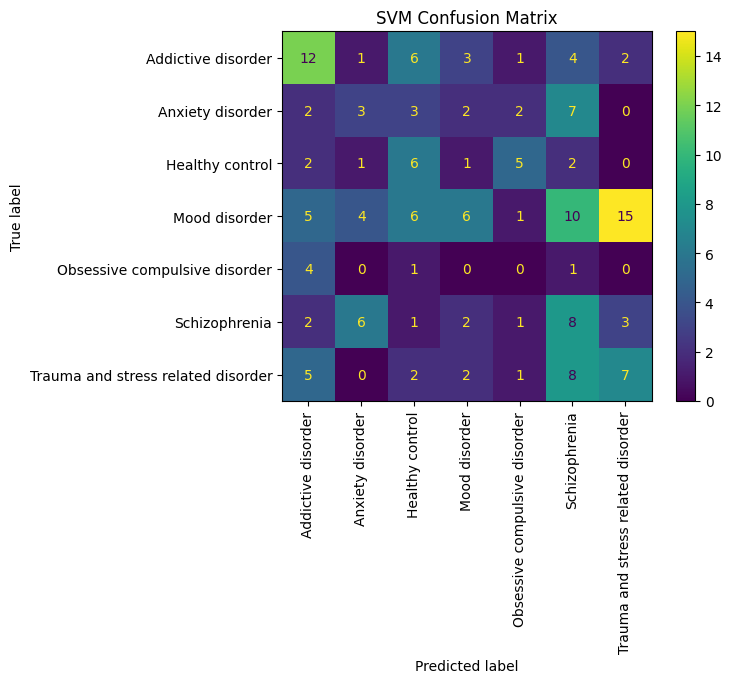

In [342]:
# Support Vector Machines

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

X = df_deduplicate.drop(columns=['main.disorder'])
y = df_deduplicate['main.disorder']


X_train, X_test, y_train, y_test = generate_train_test(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# TODO: Show change after class weight
svm_model = SVC(kernel='rbf', class_weight='balanced')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

if real_testing:
  y_frame = pd.DataFrame(y_pred, columns=['main.disorder.class'])
  test_df_ids.join(y_frame).to_csv('svm_results.csv', index=False)
else:
  print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
  print("Classification Report:")
  print(classification_report(y_test, y_pred))

  disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')
  disp.ax_.set_title("SVM Confusion Matrix")
  plt.show()

In [343]:
from sklearn.linear_model import LogisticRegression

if not real_testing:
  for disorder in ['Addictive disorder', 'Anxiety disorder', 'Mood disorder', 'Obsessive compulsive disorder', 'Schizophrenia', 'Trauma and stress related disorder']:
    label_encoder = LabelEncoder()
    X_train, X_test, y_train, y_test = generate_train_test(X, y, test_size=0.2, random_state=10)
    X_train = X_train[y_train.isin([disorder, 'Healthy control'])]
    y_train = y_train[y_train.isin([disorder, 'Healthy control'])]
    X_test = X_test[y_test.isin([disorder, 'Healthy control'])]
    y_test = y_test[y_test.isin([disorder, 'Healthy control'])]

    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.fit_transform(y_test)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)



    """
    xgb_model = xgb.XGBClassifier(n_estimators=150)

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    """

    model = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        l1_ratio=0.5,
        C=1.0,
        max_iter=2500,
        tol=1e-4,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f"Accuracy: {accuracy_score(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred))}")
    print("Classification Report:")
    print(classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred)))

Accuracy: 0.7209302325581395

Classification Report:
                    precision    recall  f1-score   support

Addictive disorder       0.82      0.77      0.79        30
   Healthy control       0.53      0.62      0.57        13

          accuracy                           0.72        43
         macro avg       0.68      0.69      0.68        43
      weighted avg       0.73      0.72      0.73        43

Accuracy: 0.8620689655172413

Classification Report:
                  precision    recall  f1-score   support

Anxiety disorder       0.88      0.88      0.88        17
 Healthy control       0.83      0.83      0.83        12

        accuracy                           0.86        29
       macro avg       0.86      0.86      0.86        29
    weighted avg       0.86      0.86      0.86        29

Accuracy: 0.8253968253968254

Classification Report:
                 precision    recall  f1-score   support

Healthy control       0.75      0.63      0.69        19
  Mood disor

0.37349397590361444
                                    precision    recall  f1-score   support

                Addictive disorder       0.42      0.59      0.49        29
                  Anxiety disorder       0.00      0.00      0.00        25
                   Healthy control       0.46      0.38      0.41        16
                     Mood disorder       0.44      0.69      0.54        49
     Obsessive compulsive disorder       0.25      0.20      0.22         5
                     Schizophrenia       0.11      0.09      0.10        22
Trauma and stress related disorder       0.20      0.10      0.13        20

                          accuracy                           0.37       166
                         macro avg       0.27      0.29      0.27       166
                      weighted avg       0.30      0.37      0.32       166



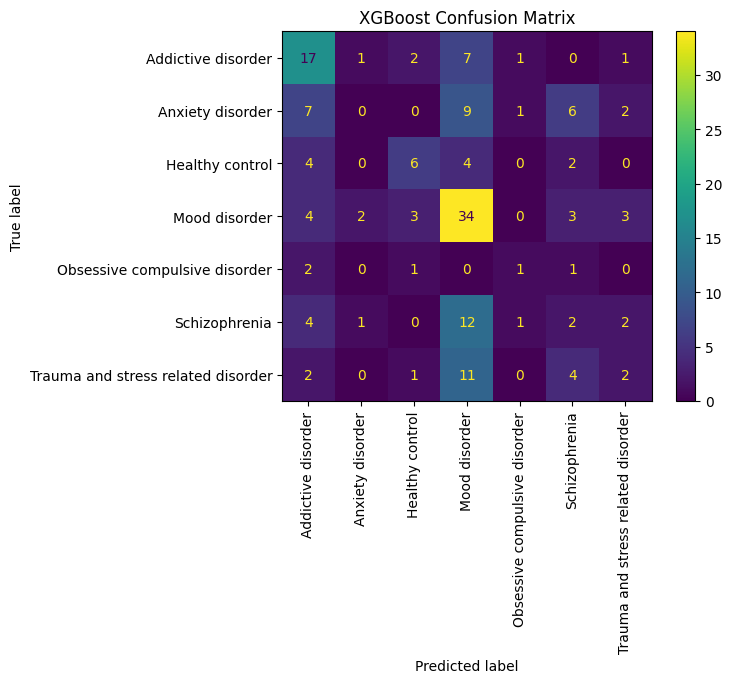

In [344]:
import xgboost as xgb

label_encoder = LabelEncoder()

xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

X_train, X_test, y_train, y_test = generate_train_test(X, y, test_size=0.2, random_state=42)
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

if real_testing:
  y_frame = pd.DataFrame(y_pred, columns=['main.disorder.class'])
  test_df_ids.join(y_frame).to_csv('xgb_results.csv', index=False)
else:
  print(accuracy_score(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred)))
  print(classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred)))
  disp = ConfusionMatrixDisplay.from_predictions(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred), xticks_rotation='vertical')
  disp.ax_.set_title("XGBoost Confusion Matrix")
  plt.show()

Text(0.5, 0, 'XGBoost Feature Importance')

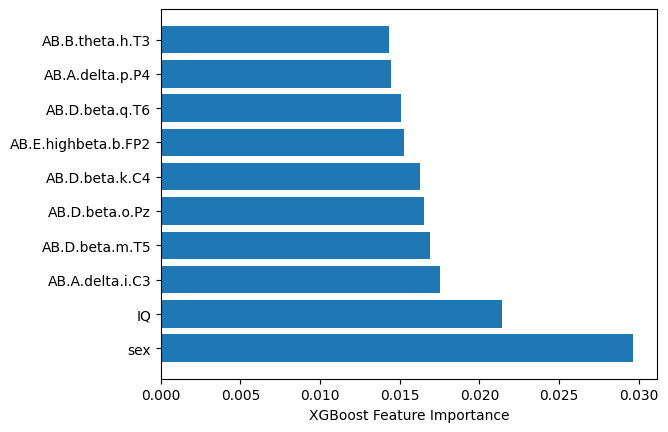

In [345]:
sorted_idx = xgb_model.feature_importances_.argsort()[::-1][:10]
plt.barh(X.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")

0.3192771084337349
                                    precision    recall  f1-score   support

                Addictive disorder       0.26      0.38      0.31        29
                  Anxiety disorder       0.40      0.08      0.13        25
                   Healthy control       0.27      0.25      0.26        16
                     Mood disorder       0.38      0.67      0.49        49
     Obsessive compulsive disorder       1.00      0.20      0.33         5
                     Schizophrenia       0.14      0.05      0.07        22
Trauma and stress related disorder       0.11      0.05      0.07        20

                          accuracy                           0.32       166
                         macro avg       0.37      0.24      0.24       166
                      weighted avg       0.31      0.32      0.27       166



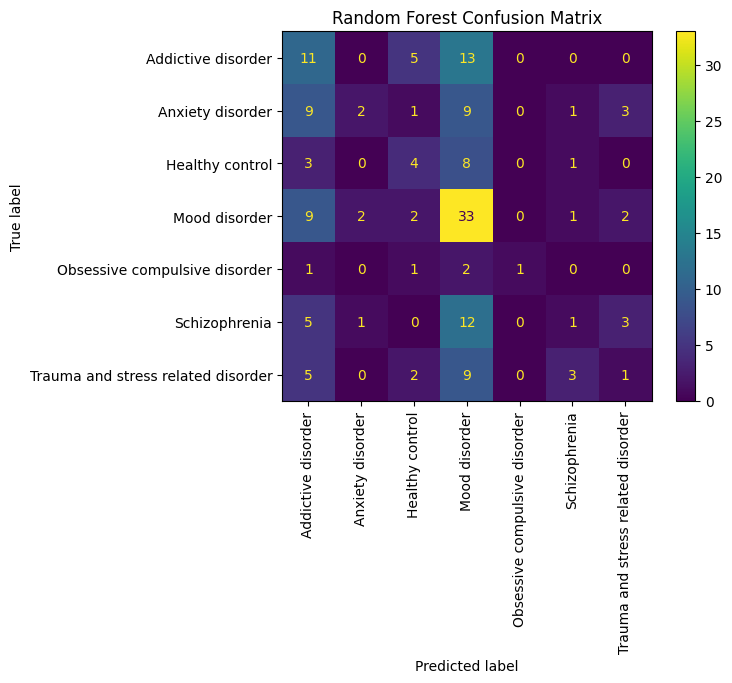

In [346]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=20)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

if real_testing:
  y_frame = pd.DataFrame(y_pred, columns=['main.disorder.class'])
  test_df_ids.join(y_frame).to_csv('rf_results.csv', index=False)
else:
  print(accuracy_score(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred)))
  print(classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred)))
  disp = ConfusionMatrixDisplay.from_predictions(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred), xticks_rotation='vertical')
  disp.ax_.set_title("Random Forest Confusion Matrix")
  plt.show()

In [347]:
import pandas as pd

file_a = '/content/Train_and_Validate_EEG.csv'
file_b = '/content/EEG.machinelearing_data_BRMH.csv'

df_a = pd.read_csv(file_a)
df_b = pd.read_csv(file_b)
df_b = df_b.rename(columns={'no.': 'ID'})

df_b = df_b[df_b['ID'].isin(df_a['ID'])]

res = pd.concat([df_a, df_b])
res.sort_values(by=['age','eeg.date','education','IQ'], inplace=True, kind='stable')

csv_file_path = '/content/result.csv'
res.to_csv(csv_file_path, index=False)